Автокодировщики - это класс нейронных сетей, которые пытаются реконструировать входные данные с применением обратного распространения. Автокодировщик состоит из двух частей: кодировщик и декодер. Кодировщик читает входные данные и сжимает их, порождая более компактное представление, а декодер читает это представление и пытается восстановить по нему вход. Иными словами, автокодировщик пытается обучить тождественную функцию, минимизируя ошибку реконструкции.
На первый взгляд, тождественная функция не представляет ничего интересного, но важно, как именно производится обучение. Число скрытых слоев автокодировщика обычно меньше числа входных (и выходных) блоков. Это вынуждает кодировщик обучаться сжатому представлению входа, которое декодер реконструирует. Если входные данные обладают структурой в виде корреляций между входными признаками, то автокодировщик выявит некоторые корреляции и в итоге обучится представлению данных меньшей размерности аналогично тому, как это делается в методе главных компонент (principal component analysis, РСА)

Обучив автокодировщик, декодер обычно отбрасывают и используют только кодировщик для порождения компактных представлений входных данных. Можно вместо этого использовать кодировщик как детектор признаков, порождающий компактное, семантически полноценное представление входа, и построить классификатор, присоединив к скрытому слою слой с функцией активации softmax.

Ранее мы уже встречались с погружениями слов, в результате чего получается вектор, представляющий смысл слова в контексте других слов, совместно с которыми оно встречается. А сейчас мы посмотрим, как построить аналогичные векторы для предложений. Предложение - это последовательность слов, а вектор предложения представляет его смысл.
Самый простой способ построить вектор предложения - сложить все векторы слов и поделить сумму на число слов. Но в этом случае предложение трактуется как мешок слов, и порядок слов не принимается во внимание. При таком подходе предложения The dog bit the man (Собака укусила человека) и The man bit the dog (Человек укусил собаку) считались бы идентичными. LSTM предназначена для работы с входными последовательностями и учитывает порядок слов, поэтому является более естественным представлением предложения.

### ИСТОЧНИКИ

https://www.kaggle.com/tunguz/russian-glove/downloads/russian-glove.zip/1



In [105]:
import collections
import nltk
import os
import numpy as np

In [258]:
def stream_sentences(src = "data/poems.txt"):
    file_path_src = src
    allHaiku = []
    with open(file_path_src, encoding="utf-8") as f:
        lines = f.readlines()
        by3lines = []
        for line in lines:
            if line.strip() == "":
                allHaiku.append(by3lines)
                by3lines = []
            else:
                by3lines.append(line.lower())
    return allHaiku

In [6]:
def to_oneline(data):
    return ["".join(row) for row in data]

In [264]:
def get_sentences(file):
    return to_oneline(stream_sentences(file))

In [460]:
sents = get_sentences("data/poems_fix.txt")

Download glove file from Kaggle to data directory

https://www.kaggle.com/tunguz/russian-glove

TODO: request file from shareable URL

In [90]:
def load_glove_vectors(glove_file, embed_size=300):
    words = [
        "PAD",
        "UNK"]
    vects = [
        np.zeros((embed_size)), # PAD
        np.random.uniform(-1, 1, embed_size)] # UNK

    fglove = open(glove_file, "rb")
    for line in fglove:
        cols = line.strip().split()
        word = cols[0].decode('utf-8')
        vect = np.array([float(v) for v in cols[1:]])
        words.append(word)
        vects.append(vect)

    vocab = {w: i for i, w in enumerate(words)}
    return words, vocab, np.array(vects)

In [91]:
words, vocab, embeddings = load_glove_vectors("data/multilingual_embeddings.ru")

In [130]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="data/multilingual_embeddings.ru", word2vec_output_file="data/gensim_glove_vectors.txt")


(63068, 300)

In [131]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("data/gensim_glove_vectors.txt", binary=False)

In [133]:
glove_model.most_similar("и")

[('оборачиваетесь', 0.7298823595046997),
 ('а', 0.7228611707687378),
 ('черно', 0.654677152633667),
 ('обеспеченные', 0.6393757462501526),
 ('поднимаются', 0.6386812925338745),
 ('мерцающее', 0.6307729482650757),
 ('разбираем', 0.6296200752258301),
 ('маршировать', 0.6277832984924316),
 ('поступая', 0.6192404627799988),
 ('повторяли', 0.6133629679679871)]

In [146]:
glove_model.similar_by_vector(embeddings[vocab["и"]])[1][0]

'оборачиваетесь'

In [80]:
embeddings.shape

(63070, 300)

In [81]:
vocab["и"]

13027

In [82]:
words[13027]

'и'

In [92]:
def safe_word2id(word, vocab):
    return vocab["UNK"] if vocab.get(word) == None else vocab[word]

In [474]:
from keras.preprocessing import sequence

SEQUENCE_LEN = 20

except_words = collections.Counter()
normal_words = {}
tokens_vectors = [[w for w in nltk.word_tokenize(s)] for s in sents]
# verse_index_vectors = [[safe_word2id(w, vocab) for w in s] for s in tokens_vectors]
windex_vectors = []
good_sentences = []
good_verses = []
for s in tokens_vectors:
    sent_vect = []
    unk_count = 0
    for w in s:
        i = safe_word2id(w, vocab)
        sent_vect.append(i)
        if (i == vocab["UNK"]):
            unk_count += 1
            except_words[w] += 1
        else:
            normal_words[w] = 1

    windex_vectors.append(sent_vect)
    if unk_count < 2 and s != []:
        good_sentences.append(sent_vect)
        good_verses.append(s)

# [[safe_word2id(w, vocab) for w in s] for s in tokens_vectors]
verse_index_vectors = sequence.pad_sequences(windex_vectors, SEQUENCE_LEN)

In [475]:
len(good_sentences)

1789

In [476]:
np.savetxt("data/good.txt", sequence.pad_sequences(good_sentences, SEQUENCE_LEN), delimiter="\t")
# r = np.genfromtxt("data/index.txt", delimiter="\t")

In [462]:
len(normal_words.keys())

14092

In [463]:
len(except_words.keys())

16676

In [262]:
def get_common_exceptions(sents, n = 40):
    except_words = collections.Counter()
    normal_words = {}
    tokens_vectors = [[w for w in nltk.word_tokenize(s)] for s in sents]
    # verse_index_vectors = [[safe_word2id(w, vocab) for w in s] for s in tokens_vectors]
    windex_vectors = []
    for s in tokens_vectors:
        sent_vect = []
        for w in s:
            i = safe_word2id(w, vocab)
            sent_vect.append(i)
            if (i == vocab["UNK"]):
                except_words[w] += 1
            else:
                normal_words[w] = 1

        windex_vectors.append(sent_vect)

    return except_words.most_common(n)

In [211]:
def tokens2index(tokens_vectors, seq_len = SEQUENCE_LEN):
    windex_vectors = [[safe_word2id(w, vocab) for w in s] for s in tokens_vectors]
    sequence.pad_sequences(windex_vectors, seq_len)

def index2vectors(index_vectors):
    return embeddings[index_vectors]

def vectors2tokens(vectors):
    for sent in vectors:
        print(" ".join([glove_model.similar_by_vector(word_vect)[0][0] for word_vect in sent]))

In [228]:
def replacex2y(x, y):
    file_path = 'data/poems_fix.txt'
    s = ""
    with open(file_path, 'r') as myfile:
      s = myfile.read()
    s = s.replace(x, y)
    with open(file_path, 'w') as myfile:
      myfile.write(s)

In [412]:
def a2b(b, a):
    for n in a:
        replacex2y(" " + n + " ", " " + b + " ")

In [231]:
replacex2y("\n", " \n ")

In [232]:
replacex2y(" што ", " что ")

In [235]:
replacex2y(" говна ", " дерьма ")

In [236]:
replacex2y(" говно ", " дерьмо ")

In [242]:
replacex2y(" хуй ", " хер ")

In [238]:
replacex2y(" исус ", " иисус ")

In [362]:
replacex2y(" исуса ", " иисуса ")

In [245]:
replacex2y(" глядит ", " смотрит ")

In [417]:
replacex2y(" тихонько ", " тихо ")
replacex2y(" тихонечко ", " тихо ")

In [252]:
replacex2y(" чаю ", " чая ")

In [271]:
replacex2y(" жопа ", " опа ")

In [317]:
replacex2y(" жопы ", " мат ")

In [318]:
replacex2y(" жопе ", " мат ")

In [319]:
replacex2y(" сука ", " мат ")

In [320]:
replacex2y(" жопу ", " мат ")

In [390]:
replacex2y(" жопой ", " мат ")

In [359]:
replacex2y(" минет ", " мат ")

In [278]:
replacex2y(" молчит ", " молчат ")

In [281]:
replacex2y(" пиздец ", " конец ")

In [425]:
replacex2y(" глядят ", " смотрят ")
replacex2y(" гляжу ", " смотрю ")
replacex2y(" глядишь ", " глядишь ")

In [288]:
replacex2y(" ево ", " его ")

In [293]:
replacex2y(" чтото ", " что то ")

In [322]:
replacex2y(" гдето ", " где то ")

In [326]:
replacex2y(" ктото ", " кто то ")

In [355]:
replacex2y(" изза ", " из за ")

In [428]:
replacex2y(" както ", " как то ")
replacex2y(" чтонибудь ", " что нибудь ")

In [364]:
replacex2y(" наутро ", " на утро ")

In [337]:
replacex2y(" иль ", " или ")

In [324]:
replacex2y(" щас ", " сейчас ")

In [454]:
replacex2y(" ещо ", " еще ")
replacex2y(" умрем ", " умрём ")

In [328]:
replacex2y(" вобще ", " вообще ")

In [330]:
replacex2y(" покуда ", " пока ")

In [332]:
replacex2y(" чорных ", " чёрных ")

In [342]:
replacex2y(" чорный ", " чёрный ")

In [343]:
replacex2y(" чорные ", " чёрные ")

In [386]:
replacex2y(" чорное ", " чёрное ")

In [336]:
replacex2y(" страшней ", " страшнее ")

In [340]:
replacex2y(" рукою ", " рукой ")

In [427]:
replacex2y(" весною ", " весной ")
replacex2y(" порою ", " порой ")
replacex2y(" зовёт ", " зовет ")
replacex2y(" толпою ", " толпой ")
replacex2y(" своею ", " своей ")

In [433]:
a2b("нечаянно", ["невзначай"])

In [436]:
names = [
 'олег',
 'оксана',
 'аркадий',
 'глеб',
 'олега',
 'николая',
 'геннадий',
 'евгений',
 'семён',
 'петра',
 'зухра',
 'оксану',
 'илья',
 'глеба',
 'олегу',
 'оксане',
 'иван',
 'семен',
 'ольга',
 'анатолий',
 'зульфия',
 'оксаны',
 'пётр',
 'зоя',
 'руфь',
 'вениамин',
 'антон',
 'путин',
 'петру',
 'шаинский',
 'игорь',
 'андрей',
 'семёна',
 'пушкин',
 'гагарин',
 'павел',
 'зухры',
 'илье',
 'оксаной',
 'ильич',
 'константин',
 'иннокентий',
 'николаем',
 'зинаида',
 'зульфии',
 'зухре',
 'ольги',
 'николаю',
 'олегом',
 'зои',
 'петрович',
 'аделаида',
 'марина',
 'афанасий',
 'глебу',
 'зульфию',
 'лариса',
 'василий',
 'петр',
 'муму',
 'татьяна',
 'зое',
 'ольгу',
 'ильи',
 'серёжа',
 'маша',
 'юра',
 'друзь',
 'михаил',
 'герасим',
 'игоря',
 'ленин',
 'аркадию',
 'илью',
 'андрея',
 'ильича',
 'саша',
 'эммануил',
 'зухру',
 'иуда',
 'фёдор',
 'боярский',
 'олеге',
 'петыр',
 'алексей',
 'ольгой',
 'кобзон',
 'коля',
 'оксан',
 'ивана',
]

for n in names:
    replacex2y(" " + n + " ", " имя ")

In [434]:
names = [
 'борщ',
 'пельмени',
 'водку',
 'пирожки',
 'пирожок',
 'пельменей',
 'омлет',
 'кастрюлю',
 'борща',
 'солью',
 'колбасы',
 'арбузы',
 'пельменя',
 'пельмень',
 'котлеты',
]

for n in names:
    replacex2y(" " + n + " ", " еда ")

In [413]:
a2b("умер", [
    "помер",
    "сдох",
])

In [456]:
a2b("мат", [
    "срать",
    "мудак",
    "блядь",
    "блять",
    "попу",
    "говном",
])

In [451]:
a2b("коробка", ["гроб"])
a2b("коробки", ["гроба", "гробы"])
a2b("могилы", ["могил"])

In [457]:
list(map(lambda x: x[0], get_common_exceptions(get_sentences("data/poems_fix.txt"), 150)))

['седой',
 'седая',
 'рублей',
 'жених',
 'косой',
 'семнадцать',
 'ночами',
 'подъезда',
 'крикнул',
 'лужи',
 'москву',
 'горько',
 'приснился',
 'сантехник',
 'снится',
 'пятьсот',
 'трамвае',
 'ежа',
 'усталый',
 'гладит',
 'вибратор',
 'зонт',
 'воет',
 'подъезде',
 'трамвай',
 'тапки',
 'молчу',
 'курю',
 'украдкой',
 'попробуй',
 'запел',
 'плюнул',
 'шорох',
 'трусах',
 'москва',
 'горлу',
 'девчонка',
 'палач',
 'шагает',
 'крым',
 'срывает',
 'целовал',
 'мордой',
 'трогают',
 'кончилась',
 'енота',
 'лежим',
 'бомж',
 'раскинув',
 'убей',
 'уставший',
 'трамвая',
 'уснул',
 'воскрес',
 'журавлей',
 'старенький',
 'гуляет',
 'колготки',
 'бредёт',
 'лежишь',
 'промолвил',
 'четырнадцать',
 'поцеловал',
 'ползи',
 'дорешал',
 'стучится',
 'утру',
 'трахаться',
 'плаще',
 'ёж',
 'портфель',
 'бухло',
 'пляшут',
 'крематорий',
 'обнявшись',
 'трусов',
 'буратино',
 'тёплый',
 'цыганка',
 'дедмороза',
 'весенний',
 'гладить',
 'ждёшь',
 'глядишь',
 'буркнул',
 'село',
 'речке',
 

In [472]:
vocab["ну"]

50816

In [97]:
verse_index_vectors.shape

(7509, 20)

In [104]:
np.savetxt("data/index.txt", verse_index_vectors, delimiter="\t")
# r = np.genfromtxt("data/index.txt", delimiter="\t")

Модель автокодировщика принимает последовательность GloVe-векторов слов и обучается порождать другую последовательность, похожую на входную. LSTM-кодировщик сжимает последовательность в контекстный вектор фиксированной длины, по которой LSTM-декодер реконструирует исходную последовательность.

In [107]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function
from __future__ import absolute_import
from __future__ import unicode_literals
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input
from keras.layers.core import RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing import sequence
import collections
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt
from time import gmtime, strftime

In [108]:
# msin
def compute_cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

In [109]:
# split sentences into training and test
train_size = 0.7
Xtrain, Xtest = train_test_split(verse_index_vectors, train_size=train_size)
print("number of sentences: ", len(verse_index_vectors))
print(Xtrain.shape, Xtest.shape)

number of sentences:  7509
(5256, 20) (2253, 20)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [110]:
def sentence_generator(X, embeddings, batch_size):
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size: (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [111]:
embeddings.shape

(63070, 300)

In [112]:
Xtrain.shape

(5256, 20)

In [113]:
Xtest.shape

(2253, 20)

In [115]:
# define training and test generators
BATCH_SIZE = 64
train_gen = sentence_generator(Xtrain, embeddings, BATCH_SIZE)
test_gen = sentence_generator(Xtest, embeddings, BATCH_SIZE)

In [160]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import unicode_literals
from time import gmtime, strftime
from keras.callbacks import TensorBoard
import os


def make_tensorboard(set_dir_name=''):
    tictoc = strftime("%a_%d_%b_%Y_%H_%M_%S", gmtime())
    directory_name = tictoc
    log_dir = set_dir_name + '_' + directory_name
    os.mkdir(log_dir)
    tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, )
    return tensorboard

In [161]:
# define autoencoder network
EMBED_SIZE = 300
LATENT_SIZE = 512

inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum",
                        name="encoder_lstm")(inputs)

decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True),
                        merge_mode="sum",
                        name="decoder_lstm")(decoded)

autoencoder = Model(inputs, decoded)

tensorboard = make_tensorboard(set_dir_name='rnn')

autoencoder.compile(optimizer="sgd", loss="mse")

In [162]:
# train
NUM_EPOCHS = 100
DATA_DIR = "data"

num_train_steps = len(Xtrain) // BATCH_SIZE
num_test_steps = len(Xtest) // BATCH_SIZE

checkpoint = ModelCheckpoint(
    filepath=os.path.join(DATA_DIR, "sent-thoughts-autoencoder.h5"),
    save_best_only=True)

history = autoencoder.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=NUM_EPOCHS,
                                    validation_data=test_gen,
                                    validation_steps=num_test_steps,
                                    callbacks=[checkpoint, tensorboard])

Epoch 1/100
82/82 [==============================] - 49s 599ms/step - loss: 0.1936 - val_loss: 0.1939
Epoch 2/100
82/82 [==============================] - 47s 576ms/step - loss: 0.1900 - val_loss: 0.1900
Epoch 3/100
82/82 [==============================] - 46s 559ms/step - loss: 0.1880 - val_loss: 0.1887
Epoch 4/100
82/82 [==============================] - 46s 565ms/step - loss: 0.1857 - val_loss: 0.1865
Epoch 5/100
82/82 [==============================] - 46s 563ms/step - loss: 0.1840 - val_loss: 0.1848
Epoch 6/100
82/82 [==============================] - 47s 569ms/step - loss: 0.1820 - val_loss: 0.1830
Epoch 7/100
82/82 [==============================] - 47s 569ms/step - loss: 0.1807 - val_loss: 0.1821
Epoch 8/100
82/82 [==============================] - 47s 570ms/step - loss: 0.1805 - val_loss: 0.1798
Epoch 9/100
82/82 [==============================] - 47s 569ms/step - loss: 0.1789 - val_loss: 0.1796
Epoch 10/100
82/82 [==============================] - 46s 563ms/step - loss: 0.177

82/82 [==============================] - 48s 585ms/step - loss: 0.1674 - val_loss: 0.1692
Epoch 81/100
82/82 [==============================] - 49s 595ms/step - loss: 0.1668 - val_loss: 0.1684
Epoch 82/100
82/82 [==============================] - 48s 582ms/step - loss: 0.1676 - val_loss: 0.1697
Epoch 83/100
82/82 [==============================] - 47s 579ms/step - loss: 0.1666 - val_loss: 0.1675
Epoch 84/100
82/82 [==============================] - 48s 583ms/step - loss: 0.1670 - val_loss: 0.1704
Epoch 85/100
82/82 [==============================] - 47s 578ms/step - loss: 0.1677 - val_loss: 0.1675
Epoch 86/100
82/82 [==============================] - 47s 576ms/step - loss: 0.1664 - val_loss: 0.1688
Epoch 87/100
82/82 [==============================] - 49s 603ms/step - loss: 0.1678 - val_loss: 0.1681
Epoch 88/100
82/82 [==============================] - 48s 582ms/step - loss: 0.1662 - val_loss: 0.1696
Epoch 89/100
82/82 [==============================] - 49s 595ms/step - loss: 0.1669 - 

In [167]:
len(Xtrain)

5256

In [166]:
len(Xtrain[Xtrain == 1])

17613

In [120]:
# extract encoder model
encoder = Model(autoencoder.input, autoencoder.get_layer("encoder_lstm").output)

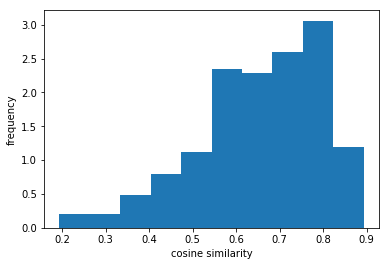

In [459]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(test_gen)
preds = autoencoder.predict(test_inputs)

# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(num_test_steps):
    xtest, _ = next(test_gen)
    ytest = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = compute_cosine_similarity(Xvec[rid], Yvec[rid])
        i += 1
    if i >= k:
        break

plt.hist(cosims, bins=10, normed=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")
plt.show()

In [124]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

In [138]:
def generator():
    
    z_dim = (LATENT_SIZE,)
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(LATENT_SIZE * 2, input_dim=LATENT_SIZE))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    model.add(Dense(SEQUENCE_LEN * EMBED_SIZE, activation='sigmoid'))
    model.add(Reshape((SEQUENCE_LEN, EMBED_SIZE)))

    x = Input(shape=z_dim)
    y = model(x)
    
    return Model(x, y)

In [141]:
def discriminator():
    inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
    encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum", name="encoder_lstm")(inputs)
    
    # Hidden layer
    y = Dense(1, activation='sigmoid')(encoded)

    # Leaky ReLU
#     model.add(LeakyReLU(alpha=0.01))

#     decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
#     decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True), merge_mode="sum", name="decoder_lstm")(decoded)

#     encoded
#     autoencoder = Model(inputs, decoded)

    return Model(inputs, y)

In [142]:
# Build and compile the Discriminator
discr = discriminator()
discr.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator()

# Generated image to be used as input
z = Input(shape=(LATENT_SIZE,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
# trainable = False should be set before compile
discr.trainable = False

# The Discriminator’s prediction
prediction = discr(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [144]:
losses = []
accuracies = []

def train(X_train, iterations, batch_size, sample_interval):
    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # -------------------------
        #  Train the Discriminator
        # -------------------------
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx] # Select a random batch of real images

        z = np.random.normal(0, 1, (batch_size, LATENT_SIZE))
        fake_imgs = generator.predict(z) # Generate a batch of fake images

        # Discriminator loss
        d_loss_real = discr.train_on_batch(real_imgs, real)
        d_loss_fake = discr.train_on_batch(fake_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, LATENT_SIZE))

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            samples(iteration)

In [156]:
def samples(iteration):

    # Sample random noise
    z = np.random.normal(0, 1, (1, LATENT_SIZE))

    # Generate images from random noise
    gen_imgs = generator.predict(z)
    
    print(gen_imgs.shape)
    print(" ".join([glove_model.similar_by_vector(v)[1][0] for v in gen_imgs[0]]))

In [153]:
embeddings[Xtrain].shape

(5256, 20, 300)

In [159]:
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')

iterations = 2000
batch_size = 64
sample_interval = 100

# Rescale -1 to 1
X_train = embeddings[Xtrain]

# Train the GAN for the specified number of iterations
train(X_train, iterations, batch_size, sample_interval)

0 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
(1, 20, 300)
антарктики удовлетворял удовлетворял удовлетворял круглосуточно законам каких прошлое достижения прошлое пиломатериалы пиломатериалы демократией демократией возникающих ничего отрастит возникающих подобное заменили
100 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
(1, 20, 300)
подали удовлетворял удовлетворял четко круглосуточно законам законам прошлое им прошлое проблемные миниатюрные демократией синтезаторе демократией миниатюрные возникающих перерывы подобное заменили
200 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
(1, 20, 300)
предпринял удовлетворял удовлетворял круглосуточно удовлетворял удовлетворял каких прошлое достижения прошлое проблемные миниатюрные демократией синтезаторе эффективен демократией возникающих возникающих подобное заменили
300 [D loss: 0.000000, acc.: 100.00%] [G loss: 16.118095]
(1, 20, 300)
вынесения предпринял удовлетворял прошлым круглосуточно способно каких каких достиж